### *E01:*
#### *Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?*

I take it the intention here is not to venture towards an MLP yet, so I will implement this as a single-layer perceptron with a softmax activation. An MLP model would undoubtedly be the better way to do this.

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt').read().splitlines()
chars = ['.'] + sorted(list(set(''.join(words))))

stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}

One issue is that as we increase the size of our input, the size of our weights matrix must grow exponentially. For 2 input characters, that's 27 x 27, and for three we'd need 27 x 27 x 27.

Since a training example only tunes a specific weight in the weight matrix with a single-layer approach, we also have to deal with the issue of sparseness -- i.e. we have fewer examples utilized to tune each of the weights, meaning we need many more gradient descent iterations (if using the same learning rate) to converge to optimal values.

In [3]:
trigram_xs, trigram_ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for i in range(len(chs) - 2):
        trigram_xs.append((stoi[chs[i]] ** 2) + stoi[chs[i+1]]) # now our input is a pair of characters rather than a single character
        trigram_ys.append(stoi[chs[i+2]])

In [4]:
trigram_xs_enc = torch.nn.functional.one_hot(torch.tensor(trigram_xs), num_classes=27*27).float()
trigram_xs_enc.shape

torch.Size([196113, 729])

In [5]:
trigram_weights = torch.randn((27 * 27, 27), requires_grad=True)

In [6]:
def train(xs, ys, weights, iters, lr, regularization, print_every=10):
    losses = []
    for i in range(iters):
        # forward pass
        logits = xs @ weights
    
        # --- softmax --- # 
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
        # < probs = torch.nn.functional.softmax(logits, dim=1) >
        # ---------------

        # get log-probability of each sample
        loss = -probs[torch.arange(len(ys)), ys].log().mean() + (regularization * torch.mean(weights ** 2))
        
        # backward pass
        loss.backward()
        
        # gradient descent step
        weights.data -= lr * weights.grad
        weights.grad = None

        if i % print_every == 0:
            print(f' Iteration {i}: loss = {loss.item()}')
        losses.append(loss.item())
    return losses


 Iteration 0: loss = 3.7779390811920166
 Iteration 50: loss = 2.6101882457733154
 Iteration 100: loss = 2.4545695781707764
 Iteration 150: loss = 2.3879470825195312
 Iteration 200: loss = 2.3501787185668945
 Iteration 250: loss = 2.325592041015625
 Iteration 300: loss = 2.308259963989258
 Iteration 350: loss = 2.2953855991363525
 Iteration 400: loss = 2.2854599952697754
 Iteration 450: loss = 2.27758526802063
 Iteration 500: loss = 2.2711870670318604
 Iteration 550: loss = 2.2658824920654297
 Iteration 600: loss = 2.2614076137542725
 Iteration 650: loss = 2.2575762271881104
 Iteration 700: loss = 2.2542552947998047
 Iteration 750: loss = 2.2513458728790283
 Iteration 800: loss = 2.248774766921997
 Iteration 850: loss = 2.2464847564697266
 Iteration 900: loss = 2.2444326877593994
 Iteration 950: loss = 2.2425830364227295


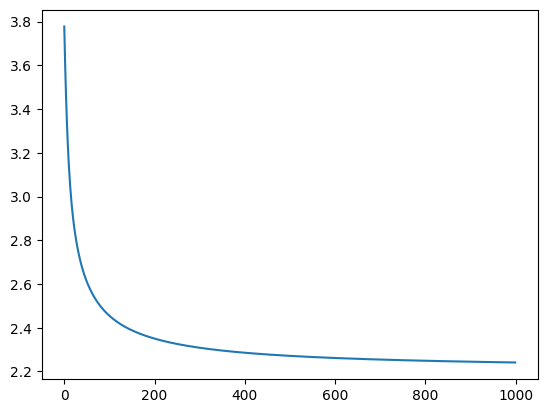

In [7]:
losses = train(trigram_xs_enc, trigram_ys, trigram_weights, iters=1000, lr=50.0, regularization=0.01, print_every=50)

import matplotlib.pyplot as plt

plt.plot(losses)

In [8]:
losses[-1]

2.2409396171569824

We see some mild improvement in the trigram model: a log-likelihood loss of 2.24 vs 2.45, which is expected, given that we now have access to more information.

We can try generating a few names with the new model:

In [9]:
def generate(ma):
    logprob_sum = 0.0
    count = 0
    ix = 0
    name = []
    count = 0
    while True:
        ix2 = torch.multinomial(ma[ix], 1, replacement=False).item()
        logprob_sum += torch.log(ma[ix, ix2])
        count += 1
        if ix2 == 0:
            break
        name.append(itos[ix2])
        ix = ix2
    return ''.join(name), logprob_sum, count


In [10]:
normalized_trigram_weights = torch.nn.functional.softmax(trigram_weights, dim=1)

In [11]:
num_generated_names = 10

for _ in range(num_generated_names):
    name, logprobsum, count = generate(normalized_trigram_weights)
    print(f"{name} (log-likelihood: {-logprobsum/count:0.3f})")

viloradyemamlamabri (log-likelihood: 2.241)
gn (log-likelihood: 3.558)
gros (log-likelihood: 2.496)
wiero (log-likelihood: 2.748)
vbrhshelaahanloadamavo (log-likelihood: 2.459)
qevitaalisededeevelealaedainelyaaalekarutuhei (log-likelihood: 2.387)
avi (log-likelihood: 1.946)
iyani (log-likelihood: 2.230)
kavaaeabmakayytalasaredau (log-likelihood: 2.549)
qniailsrashalalearoe (log-likelihood: 2.376)


Still not convincing names in my opinion, but maybe we can improve with more sophsiticated network architecture. At least our loss is lower.

### E02:
#### *Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?*

First we'll split the data into train, dev, and test:

In [12]:
# always good practice to randomize data prior to splitting
import random
random.shuffle(words)
words
train_split, dev_split = int(0.8 * len(words)), int(0.9 * len(words))

train_words, dev_words, test_words = words[:train_split], words[train_split:dev_split], words[dev_split:]

Next, we'll convert that data into the appropriate encodings for the bigram and trigram models:

In [13]:

def build_bigram_dataset(data):
    xs, ys = [], []
    for w in data:
        chs = ['.'] + list(w) + ['.']
        for i in range(len(chs) - 1):
            xs.append(stoi[chs[i]])
            ys.append(stoi[chs[i+1]])
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xs = torch.nn.functional.one_hot(xs, num_classes=27).float()
    return xs, ys

def build_trigram_dataset(data):
    xs, ys = [], []
    for w in data:
        chs = ['.'] + list(w) + ['.']
        for i in range(len(chs) - 2):
            xs.append((stoi[chs[i]] * 27) + stoi[chs[i+1]])
            ys.append(stoi[chs[i+2]])
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xs = torch.nn.functional.one_hot(xs, num_classes=27*27).float()
    return xs, ys

bigram_xs_train, bigram_ys_train = build_bigram_dataset(train_words)
bigram_xs_dev, bigram_ys_dev = build_bigram_dataset(dev_words)
bigram_xs_test, bigram_ys_test = build_bigram_dataset(test_words)

trigram_xs_train, trigram_ys_train = build_trigram_dataset(train_words)
trigram_xs_dev, trigram_ys_dev = build_trigram_dataset(dev_words)
trigram_xs_test, trigram_ys_test = build_trigram_dataset(test_words)

 Iteration 0: loss = 3.6740121841430664
 Iteration 25: loss = 2.676595687866211
 Iteration 50: loss = 2.5729410648345947
 Iteration 75: loss = 2.5378642082214355
 Iteration 100: loss = 2.520911455154419
 Iteration 125: loss = 2.5108354091644287
 Iteration 150: loss = 2.5041635036468506
 Iteration 175: loss = 2.4994544982910156
 Iteration 200: loss = 2.4959890842437744
 Iteration 225: loss = 2.49336314201355
 Iteration 250: loss = 2.491330146789551
 Iteration 275: loss = 2.489729404449463
 Iteration 300: loss = 2.4884517192840576
 Iteration 325: loss = 2.4874205589294434
 Iteration 350: loss = 2.4865779876708984
 Iteration 375: loss = 2.485882520675659
 Iteration 400: loss = 2.485302686691284
 Iteration 425: loss = 2.484814167022705
 Iteration 450: loss = 2.4844000339508057
 Iteration 475: loss = 2.4840447902679443
 Iteration 500: loss = 2.4837379455566406
 Iteration 525: loss = 2.483471393585205
 Iteration 550: loss = 2.4832379817962646
 Iteration 575: loss = 2.483032464981079
 Iterati

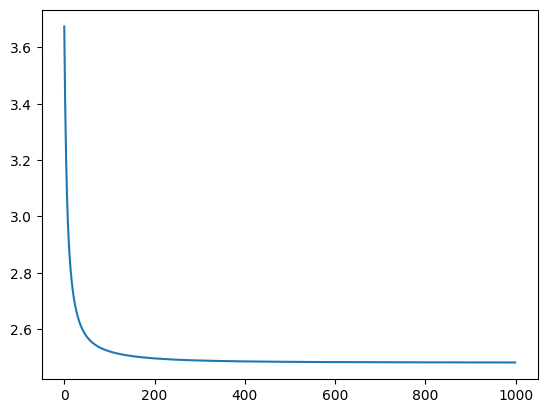

In [14]:
bigram_weights = torch.randn((27, 27), requires_grad=True)
bigram_losses = train(bigram_xs_train, bigram_ys_train, bigram_weights, iters=1000, lr=20.0, regularization=0.01, print_every=25)
plt.plot(bigram_losses)

In [29]:
def evaluate_model(xs, ys, weights):
    logits = (xs @ weights).exp()
    preds = logits / logits.sum(1, keepdim=True)
    loss = -preds[torch.arange(len(ys)), ys].log().mean()
    return loss.item()

In [16]:
evaluate_model(bigram_xs_dev, bigram_ys_dev, bigram_weights)

2.460641860961914

In [17]:
evaluate_model(bigram_xs_test, bigram_ys_test, bigram_weights)

2.461305856704712

 Iteration 0: loss = 3.75309419631958
 Iteration 25: loss = 2.832350730895996
 Iteration 50: loss = 2.5978481769561768
 Iteration 75: loss = 2.4800922870635986
 Iteration 100: loss = 2.4081530570983887
 Iteration 125: loss = 2.359316349029541
 Iteration 150: loss = 2.323650360107422
 Iteration 175: loss = 2.296219825744629
 Iteration 200: loss = 2.2743396759033203
 Iteration 225: loss = 2.2564220428466797
 Iteration 250: loss = 2.241457462310791
 Iteration 275: loss = 2.228767156600952
 Iteration 300: loss = 2.2178752422332764
 Iteration 325: loss = 2.208432674407959
 Iteration 350: loss = 2.200178384780884
 Iteration 375: loss = 2.192908763885498
 Iteration 400: loss = 2.1864640712738037
 Iteration 425: loss = 2.1807167530059814
 Iteration 450: loss = 2.175562858581543
 Iteration 475: loss = 2.1709177494049072
 Iteration 500: loss = 2.1667115688323975
 Iteration 525: loss = 2.1628851890563965
 Iteration 550: loss = 2.159390449523926
 Iteration 575: loss = 2.1561853885650635
 Iteration

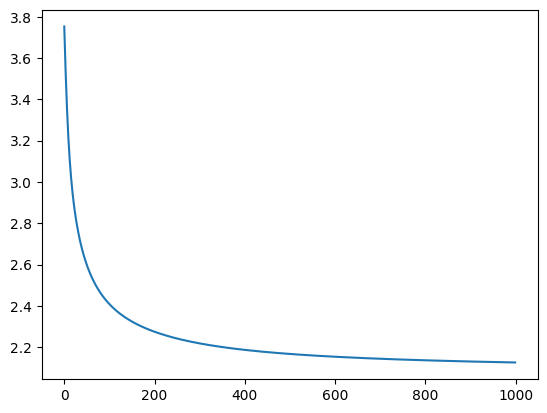

In [18]:
# reinitialize the trigram weights
trigram_weights = torch.randn((27 * 27, 27), requires_grad=True)
trigram_losses = train(trigram_xs_train, trigram_ys_train, trigram_weights, iters=1000, lr=50.0, regularization=0.01, print_every=25)
plt.plot(trigram_losses)

In [19]:
evaluate_model(trigram_xs_dev, trigram_ys_dev, trigram_weights)

2.138702392578125

In [20]:
evaluate_model(trigram_xs_test, trigram_ys_test, trigram_weights)

2.1367685794830322

We see that both models generalize fairly well, maintaining a similar loss across the train, dev, and test sets (albeit slightly higher on the dev and test sets). Once again, the trigram model achieves higher accuracy.

### E03: 
#### *Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?*

In [32]:
possible_regularizations = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
all_losses = []
models = []
for regularization in possible_regularizations:
    trigram_weights = torch.randn((27 * 27, 27), requires_grad=True)
    trigram_losses = train(trigram_xs_train, trigram_ys_train, trigram_weights, iters=1000, lr=50.0, regularization=regularization, print_every=100)
    print(f"regularization: {regularization}, dev loss: {evaluate_model(trigram_xs_dev, trigram_ys_dev, trigram_weights):0.3f}")
    all_losses.append(trigram_losses)
    models.append(trigram_weights)

 Iteration 0: loss = 3.7586708068847656
 Iteration 100: loss = 2.394470453262329
 Iteration 200: loss = 2.259982109069824
 Iteration 300: loss = 2.204493522644043
 Iteration 400: loss = 2.1735455989837646
 Iteration 500: loss = 2.153796672821045
 Iteration 600: loss = 2.1400973796844482
 Iteration 700: loss = 2.1300082206726074
 Iteration 800: loss = 2.1222431659698486
 Iteration 900: loss = 2.116067409515381
regularization: 0.0, dev loss: 2.138
 Iteration 0: loss = 3.732936382293701
 Iteration 100: loss = 2.391986608505249
 Iteration 200: loss = 2.2609481811523438
 Iteration 300: loss = 2.2058632373809814
 Iteration 400: loss = 2.1751232147216797
 Iteration 500: loss = 2.155500888824463
 Iteration 600: loss = 2.141850709915161
 Iteration 700: loss = 2.1317732334136963
 Iteration 800: loss = 2.1240155696868896
 Iteration 900: loss = 2.1178553104400635
regularization: 0.001, dev loss: 2.139
 Iteration 0: loss = 3.7610955238342285
 Iteration 100: loss = 2.4035778045654297
 Iteration 200:

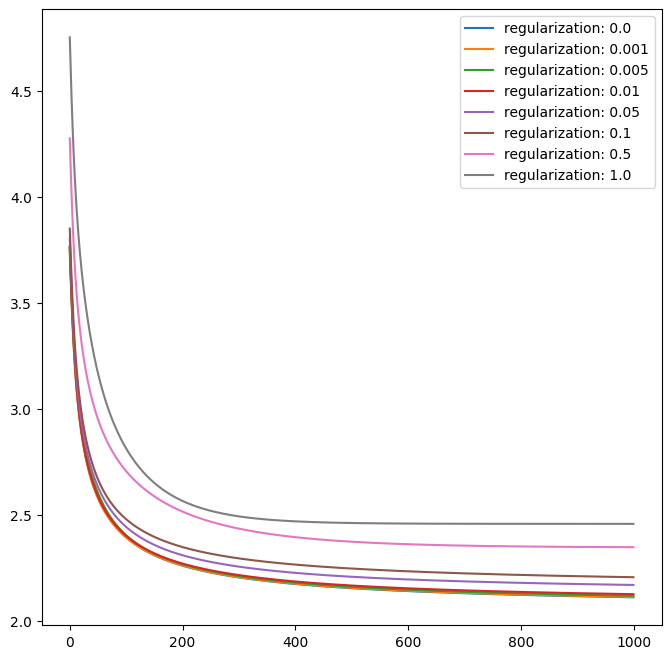

In [33]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
for i, regularization in enumerate(possible_regularizations):
    ax.plot(all_losses[i], label=f"regularization: {regularization}")
    ax.legend()

In [36]:
best_weights = models[2]
evaluate_model(trigram_xs_test, trigram_ys_test, best_weights)

2.1350443363189697

### E04: 
#### *We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?*

Instead of using the dot product to extract the correct rows of the weight matrix using one-hot vector, we can omit converting the inputs into one-hot vectors entirely, and instead use the ids to index into the appropriate indices.

In [57]:
def build_trigram_dataset(data):
    xs, ys = [], []
    for w in data:
        chs = ['.'] + list(w) + ['.']
        for i in range(len(chs) - 2):
            xs.append((stoi[chs[i]] * 27) + stoi[chs[i+1]])
            ys.append(stoi[chs[i+2]])
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

In [60]:
xs_no_onehot, ys_no_onehot = build_trigram_dataset(train_words)

In [61]:
xs_onehot = torch.nn.functional.one_hot(xs_no_onehot, num_classes=27*27).float()

In [62]:
best_weights[xs_no_onehot].shape, (xs_onehot @ best_weights).shape

(torch.Size([157114, 27]), torch.Size([157114, 27]))

In [63]:
(best_weights[xs_no_onehot] == (xs_onehot @ best_weights)).all()

tensor(True)

E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

We can modify the train function as follows:

In [75]:
def train(xs, ys, weights, iters, lr, regularization, print_every=10):
    losses = []
    for i in range(iters):
        # forward pass
        logits = weights[xs]
    
        # --- softmax --- # 
        # counts = logits.exp()
        # probs = counts / counts.sum(1, keepdim=True)
        # # < probs = torch.nn.functional.softmax(logits, dim=1) >
        # # ---------------

        # # get log-probability of each sample
        # loss = -probs[torch.arange(len(ys)), ys].log().mean() + (regularization * torch.mean(weights ** 2))

        loss = torch.nn.functional.cross_entropy(logits, ys) + (regularization * torch.mean(weights ** 2))
        
        # backward pass
        loss.backward()
        
        # gradient descent step
        weights.data -= lr * weights.grad
        weights.grad = None

        if i % print_every == 0:
            print(f' Iteration {i}: loss = {loss.item()}')
        losses.append(loss.item())
    return losses

In [77]:
xs_train, ys_train = build_trigram_dataset(train_words)

 Iteration 0: loss = 3.796067237854004
 Iteration 100: loss = 2.401005506515503
 Iteration 200: loss = 2.2656092643737793
 Iteration 300: loss = 2.209942102432251
 Iteration 400: loss = 2.1794683933258057
 Iteration 500: loss = 2.160184860229492
 Iteration 600: loss = 2.1468441486358643
 Iteration 700: loss = 2.1370341777801514
 Iteration 800: loss = 2.1295006275177
 Iteration 900: loss = 2.1235268115997314


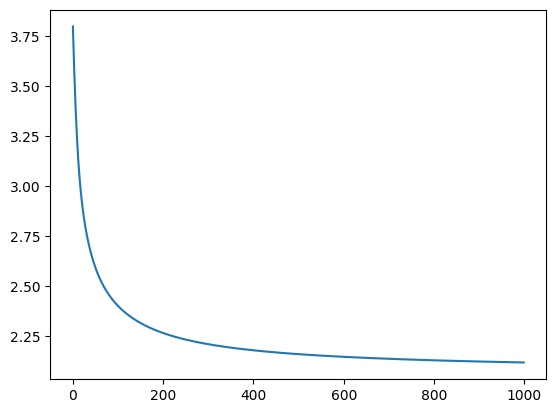

In [78]:
trigram_weights = torch.randn((27 * 27, 27), requires_grad=True)
trigram_losses = train(xs_train, ys_train, trigram_weights, iters=1000, lr=50.0, regularization=0.005, print_every=100)
plt.plot(trigram_losses)

This has the advantage of not creating multiple tensors, which should speed things up. It also makes consolidates a lot of the gradient computation and has other optimizations that pytorch executes behind the scenes.

E06: meta-exercise! Think of a fun/interesting exercise and complete it.

Instead of building a trigram model that uses the previous two characters, we could introduce some human intuition around values.

Namely, our model input contains the previous character, and then the next-most previous vowel (or '.'). Vowels in names usually take on common structures, so this could be a nice way to try to eke out some more performance from an otherwise very limited model.

In [79]:
def build_trigram_dataset_prev_vowel(data):
    xs, ys = [], []
    for w in data:
        last_vowel = 0
        chs = ['.'] + list(w) + ['.']
        for i in range(len(chs) - 1):
            xs.append((stoi[chs[i]] * 27) + stoi[chs[last_vowel]])
            ys.append(stoi[chs[i+1]])
            if chs[i] in ['a', 'e', 'i', 'o', 'u']:
                last_vowel = i

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

In [80]:
build_trigram_dataset_prev_vowel(['hello', 'world'])

(tensor([  0, 216, 135, 329, 329, 410,   0, 621, 405, 501, 339, 123]),
 tensor([ 8,  5, 12, 12, 15,  0, 23, 15, 18, 12,  4,  0]))

In [81]:
xs_train, ys_train = build_trigram_dataset_prev_vowel(train_words)
xs_dev, ys_dev = build_trigram_dataset_prev_vowel(dev_words)
xs_test, ys_test = build_trigram_dataset_prev_vowel(test_words)


 Iteration 0: loss = 3.782006025314331
 Iteration 100: loss = 2.446876049041748
 Iteration 200: loss = 2.382607936859131
 Iteration 300: loss = 2.358875274658203
 Iteration 400: loss = 2.3468096256256104
 Iteration 500: loss = 2.339616060256958
 Iteration 600: loss = 2.3348805904388428
 Iteration 700: loss = 2.331540107727051
 Iteration 800: loss = 2.3290600776672363
 Iteration 900: loss = 2.327146530151367


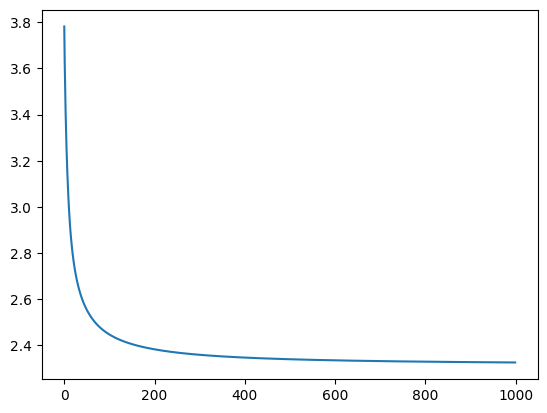

In [82]:
prev_vowel_weights = torch.randn((27 * 27, 27), requires_grad=True)
prev_vowel_losses = train(xs_train, ys_train, prev_vowel_weights, iters=1000, lr=50.0, regularization=0.005, print_every=100)
plt.plot(prev_vowel_losses)

In [98]:
def evaluate_model(xs, ys, weights):
    logits = weights[xs]
    loss = torch.nn.functional.cross_entropy(logits, ys)
    return loss.item()

In [99]:
evaluate_model(xs_dev, ys_dev, prev_vowel_weights)

2.3296713829040527

In [124]:
normalized_prev_vowel_weights = torch.nn.functional.softmax(prev_vowel_weights, dim=1)
num_generated_names = 10

for _ in range(num_generated_names):
    name, logprobsum, count = generate(normalized_prev_vowel_weights)
    print(f"{name} (log-likelihood: {-logprobsum/count:0.3f})")

rtvpa (log-likelihood: 3.504)
kbgbwsmtvvagbihqvarszvkciuowtvvzvrmbudiuuplcuyabyrfhucbaiusihqwbghucmbvqxptpmtcqvihdtcluyhhlsparfjvvwlvdtdiuhnqvgyuuyfayqyrpennsmyu (log-likelihood: 2.687)
obvvmreugtvbhsckbuyurflvxqjb (log-likelihood: 2.791)
etxxelih (log-likelihood: 3.052)
jzmkbtbaarssltplucqjfjpdhkbwtdxxswo (log-likelihood: 2.877)
sdcuiwwmmyiuwkbaretiuyrmnxzvalmtwnnfgkyuyuuucgyuurpoppxzyssrgbchyamtfpkkbwebiajvmhupldlvzbgowfhtodlduyadhdhhgjkcvzeuuhkwlqwlzgbbmyathiuuyuhwxzfrnfgyuuuihqdifmthpmdeltgnkewtxm (log-likelihood: 2.835)
iuyarftviuuugsspxbcgottdhjnfzrnkifjht (log-likelihood: 2.574)
dmbmdlo (log-likelihood: 3.026)
rvzjaadzkbmyugbmqgbdlvzrnkmb (log-likelihood: 2.731)
bmotiuiuyuuuuhspxwzfhwtplooyarfpciwo (log-likelihood: 2.681)


Absolute hot garbage. While our loss is actually lower than the bigram model, the results are in practice... not good. In order for an approach like this to work well we'd really need to include some more information in the model input, but that does not scale well with the weight matrix approach. We will fix all of these problems in the next lecture when we cover embeddings and the MLP architecture :)